# In which I am continually distracted from scraping board game info by the board games themselves. 
[Boardgamegeek.com](https://boardgamegeek.com/) (BGG) is an online community for board game enthusiasts that provides social network features as well as a huge database of board games with ratings, comments, statistics, and other features of each game. Now, I quite like board games, especially the more complex Euro-style games (like Settlers of Catan and Ticket to Ride). But what I *really* like is a gigantic steaming pile of data like this site. BGG also has a (recently improved) API so we can mostly avoid the heartache of trying to parse HTML from a page in the wild. 

Once I have all this data I'm going to fill a pool with it and swim around Scrooge McDuck style. Or maybe I'll analyze it. Ultimately I'm going to try my hand at a recommender system both for games and for finding friends on the site (known as GeekBuddies). I want to do some basic exploratory analysis too though. Don't you want to know if board games are getting easier or harder over the last few years? How the popularity of different game categories has changed over time? What people actually do when presented with 10-star rating system... is the average rating a 5???

>## Tools Covered:
- `requests` package for retrieving HTML pages and using APIs
- `bs4` package for parsing HTML and XML documents
- `sqlite3` for interacting with local SQLite databases via python
- `df.to_sql()` and `df.from_sql()` for seamlessly moving data between a DB and pandas DF

In [1]:
import requests
from bs4 import BeautifulSoup
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
from time import sleep
import timeit

import snips as snp  # my snippets
snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

### The Anatomy of Scraping and API Calls
Using `requests` with `BeatifulSoup` is almost too easy. You send the server a single URL and it sends you back a response - you'll get HTML if your URL was just a normal page on the site, and you'll get XML back if instead your URL reflects the API format. (I'm just talking about the BGG API here - the documentation for which is [here (version 1)](https://boardgamegeek.com/wiki/page/BGG_XML_API#) and [here (version 2)](https://boardgamegeek.com/wiki/page/BGG_XML_API2#toc11)). Then you simply parse the response text with `BeatifulSoup` using the appropriate parser. Here is the basic anatomy of what we'll be doing (this example is an API call, returning XML):

In [2]:
r = requests.get("http://www.boardgamegeek.com/xmlapi2/user?name=Zazz&top=1")
soup = BeautifulSoup(r.text, "xml")  # Use the xml parser for API responses and the html_parser for scraping
print(r.status_code)  # 404 not found and the like. Hopefully 200!

200


In [ ]:
r.text

# Scraping to Get Game IDs
In an ideal world I'd have access to a list of all game IDs and a list of user names, and I could just start making API requests. This is not an ideal world, so instead I'm going to scrape the "Browse" section of BGG to acquire a list of game IDs. 

The `requests` package can be used in conjuntion with `bs4` to do some pretty powerful web scraping stuff. Here I'm going to request the HTLM for each page in the pages of results for browsing all boardgames. This actually works quite well as I can specify that I want to browse a list sorted by number of ratings, in descending order, and in this way I can cut off the scraping when I reach whatever ratings sparsity I want (maybe somewhere around 100 ratings per game?). I'm starting the scrape from [this page](https://boardgamegeek.com/browse/boardgame/page/1?sort=numvoters&sortdir=desc). Remember to code in a short time delay (one or two seconds) between server requests, otherwise you might get your IP blacklisted, you hacker! For now the only info I'll pull is the game ID (an integer), the game name, the number of ratings, and the URL for a thumbnail pic of the game.

In [3]:
# Initialize a DF to hold all our scraped game info
df_all = pd.DataFrame(columns=["id", "name", "nrate", "pic_url"])
min_nrate = 1e5
npage = 1

# Scrap successful pages in the results until we get down to games with < 1000 ratings each
while min_nrate > 1000:
    # Get full HTML for a specific page in the full listing of boardgames sorted by 
    resp = requests.get("https://boardgamegeek.com/browse/boardgame/page/%i?sort=numvoters&sortdir=desc" % (npage,))
    soup = BeautifulSoup(resp.text, "html.parser")    
    
    # Get rows for the table listing all the games on this page
    table = soup.find_all("tr", attrs={"id": "row_"})  # Get list of all the rows (tags) in the list of games on this page
    df = pd.DataFrame(columns=["id", "name", "nrate", "pic_url"], index=range(len(table)))  # DF to hold this pages results
    
    # Loop through each row and pull out the info for that game
    for idx, row in enumerate(table):
        # Row may or may not start with a "boardgame rank" link, if YES then strip it
        links = row.find_all("a")
        if "name" in links[0].attrs.keys():
            del links[0]
        gamelink = links[1]  # Get the relative URL for the specific game
        gameid = int(gamelink["href"].split("/")[2])  # Get the game ID by parsing the relative URL
        gamename = gamelink.contents[0]  # Get the actual name of the game as the link contents
        imlink = links[0]  # Get the URL for the game thumbnail
        thumbnail = imlink.contents[0]["src"]

        ratings_str = row.find_all("td", attrs={"class": "collection_bggrating"})[2].contents[0]
        nratings = int("".join(ratings_str.split()))

        df.iloc[idx, :] = [gameid, gamename, nratings, thumbnail]

    # Concatenate the results of this page to the master dataframe
    min_nrate = df["nrate"].min()  # The smallest number of ratings of any game on the page
    print("Page %i scraped, minimum number of ratings was %i" % (npage, min_nrate))
    df_all = pd.concat([df_all, df], axis=0)
    npage += 1
    sleep(2) # Keep the BGG server happy.

Page 1 scraped, minimum number of ratings was 12941
Page 2 scraped, minimum number of ratings was 8615
Page 3 scraped, minimum number of ratings was 6191
Page 4 scraped, minimum number of ratings was 4761
Page 5 scraped, minimum number of ratings was 3873
Page 6 scraped, minimum number of ratings was 3294
Page 7 scraped, minimum number of ratings was 2828
Page 8 scraped, minimum number of ratings was 2452
Page 9 scraped, minimum number of ratings was 2197
Page 10 scraped, minimum number of ratings was 1973
Page 11 scraped, minimum number of ratings was 1757
Page 12 scraped, minimum number of ratings was 1619
Page 13 scraped, minimum number of ratings was 1456
Page 14 scraped, minimum number of ratings was 1336
Page 15 scraped, minimum number of ratings was 1247
Page 16 scraped, minimum number of ratings was 1163
Page 17 scraped, minimum number of ratings was 1093
Page 18 scraped, minimum number of ratings was 1013
Page 19 scraped, minimum number of ratings was 951


In [4]:
df = df_all.copy()
# Reset the index since we concatenated a bunch of DFs with the same index into one DF
df.reset_index(inplace=True, drop=True)
# Write the DF to .csv for future use
df.to_csv("bgg_gamelist.csv", index=False, encoding="utf-8")
df.head()

,id,name,nrate,pic_url
0,13,Catan,64574,//cf.geekdo-images.com/images/pic2419375_mt.jpg
1,822,Carcassonne,63809,//cf.geekdo-images.com/images/pic2337577_mt.jpg
2,30549,Pandemic,58328,//cf.geekdo-images.com/images/pic1534148_mt.jpg
3,36218,Dominion,53488,//cf.geekdo-images.com/images/pic394356_mt.jpg
4,68448,7 Wonders,48593,//cf.geekdo-images.com/images/pic860217_mt.jpg


In [5]:
print("Number of games with > 1000 ratings is approximately %i" % (len(df),))
print("Total number of ratings from all these games is %i" % (df["nrate"].sum(),))

Number of games with > 1000 ratings is approximately 1900
Total number of ratings from all these games is 7544367


Lets get a sense of how common different amounts of ratings are by histogramming.

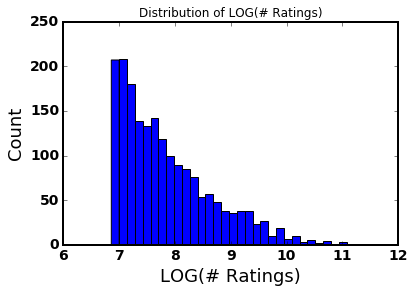

In [6]:
import numpy as np
fig, ax = plt.subplots()
snp.labs("LOG(# Ratings)", "Count", "Distribution of LOG(# Ratings)")
__ = ax.hist(np.log(df["nrate"].astype(float)), bins=30)

# Using API to Get Ratings for Games
Now that we have the integer game IDs, the specific ratings information for any game can be had, in XML form, directly from the API. This XML response is a lot cleaner and easier to parse than the HTML we had to scrape to get our list of game IDs. Each rating lives in it's own simple `comment` type div.

In [7]:
# Getting the ratings of specific board game (each is in a "comment" div)
r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=213578&ratingcomments=1")
soup = BeautifulSoup(r.text, "xml")
comments = soup("comment")
comments

[<comment rating="10" username="naruko" value=""/>,
 <comment rating="10" username="JavierKensei" value=""/>,
 <comment rating="10" username="Grizzlylizard" value=""/>,
 <comment rating="10" username="Globulor" value="This kickstarter rocks!!!!!"/>,
 <comment rating="10" username="Yue99" value="Very good project, awesome minis!"/>,
 <comment rating="10" username="Nargash" value="This game is now in kickstarter and will be so amayzing !!!!  Come and plede with all community help us to improve all we can have and reach in SG."/>,
 <comment rating="10" username="Wimmoes" value=""/>,
 <comment rating="9" username="Tefen" value=""/>,
 <comment rating="8" username="Boost3r" value=""/>,
 <comment rating="1" username="cadwal" value="Kickstarter exclusive miniatures make it impossible to complete the collection after release."/>]

In [8]:
comments[0]["username"]

'naruko'

### Paged API Calls
With the BGG API ratings retrieval is paged, meaning when you send the URL requesting ratings for a particular item, you get back only a chunk of 100 ratings at a time. The chunk you get is controlled by the `page` parameter of the request so you should make a loop which keeps sending request, incrementing page each time, until the result is empty (you incremented past the last page of stuff). Remember that an empty list will evaluate to boolean `False` so we can use that to control our loop.

# Start Small: Get A Toy Data Set
Ultimately I am going to want to pull ratings from all games with any significant number of ratings (like 50 or more). That is going to end up being  shit ton of games and ratings. More than my laptop can handle. So lets first get a toy data set to play with, so we can do all our troubleshooting and development with dataframe that won't melt my harddrive. 

In [10]:
print("Dropping the 20 most-rated games would give a total number of ratings of %i" 
      % (df.loc[500:, "nrate"].sum(),))

Dropping the 20 most-rated games would give a total number of ratings of 2575838


In [11]:
print("Thresholding at 2000 ratings gives %i games and %i total ratings"
     % (df.loc[df["nrate"] < 2000, "nrate"].count(), 
        df.loc[df["nrate"] < 2000, "nrate"].sum()))

Thresholding at 2000 ratings gives 915 games and 1243235 total ratings


In [46]:
# Restrict the data set to fewer games that have fewer ratings (our toy data set!)
df_toy = df.loc[df["nrate"] < 2000, ].copy()

I think I'll stick with the 2000 ratings or fewer threshold. Since we stopped scraping board games at 1000 ratings this is kind of a small range - only games with between 1000 and 2000 ratings! That's OK, it's just a toy set for now. Since we are going to grab about 1.2 million ratings in total, if we do it just in batches of 100, with a delay of 2 seconds per API ping, this would take an unacceptably long time. 

### Getting Ratings for Multiple Games at Once
Instead of going game-by-game, each API call I make will request the $n^{th}$ page of ratings for multiple games at once - I can do this just by providing a list of integer game IDs in the `id=` parameter of the URL. I'll set up a vector that initializes to the number of *full* (meaning has 100 comments) pages for each game ID, and then after each API call I'll decrement every element by one. Each call will include in its `id=` list only game ids who still have $npages > 0$. Even when we provide a list of IDs the response comments don't have any attribute indicating which game they belong to (why???), but they will be ordered according to the `id` list. That's why I will only be pulling *full* pages of ratings - that allows me to know that the first 100 comments map to the first game ID that I provided etc. At the end we can run through game-by-game and grab the last partial page of ratings for each game. And finally, to complicate things even further, we can't provide a list of all the game ids at once because the response will be too big, so we'll have to do the above procedure on just one chunk of the games at a time. 

In [47]:
# Prepare a "# of FULL pages of ratings" column to track # API calls needed
df_toy["nfullpages"] = (df_toy["nrate"]-50).apply(round, ndigits=-2)/100  # Round DOWN to nearest 100

,id,name,nrate,pic_url,nfullpages
1672,31638,Memoir '44: Air Pack,1112,//cf.geekdo-images.com/images/pic244022_mt.jpg,11
1524,310,Wizard's Quest,1225,//cf.geekdo-images.com/images/pic157002_mt.jpg,12
1044,156776,"Warhammer 40,000: Conquest",1891,//cf.geekdo-images.com/images/pic2079275_mt.jpg,18
1003,115098,Quarriors! Quarmageddon,1964,//cf.geekdo-images.com/images/pic1178902_mt.jpg,19
1607,87890,Prêt-à-Porter,1158,//cf.geekdo-images.com/images/pic1055299_mt.jpg,11
988,128667,Samurai Sword,1994,//cf.geekdo-images.com/images/pic1411222_mt.jpg,19


### Writing Results to a SQLite Database
Eventually this is going to be a big data set - a lot more than 1000 games a lot more than 1.2 million ratings. So let's set up the infrastructure of a local database right from the start. Every time I finish grabbing full pages of ratings from a chunk of games I'll push the resulting dataframe into this database. 

In [50]:
# Create the database and make a cursor to talk to it.
import sqlite3
connex = sqlite3.connect("bgg_ratings.db")  # Opens file if exists, else creates file
cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results

In [48]:
#############################################################
# Gathering all ratings from all games in toy data set
#############################################################
# Get ratings page-by-page for all games, but do it in chunks of 250 games
for nm, grp in df_toy.groupby(np.arange(len(df_toy))//150):
    # Initialize a DF to hold all the responses for this chunk of games
    df_ratings = pd.DataFrame(columns=["gameid", "username", "rating"], index=range(grp["nrate"].sum()+100000))

    # Initialize indices for writing to the ratings dataframe
    dfidx_start = 0
    dfidx = 0
    
    # For this group of games, make calls until all FULL pages of every game have been pulled
    pagenum = 1
    while len(grp[grp["nfullpages"] > 0]) > 0: 
        # Get a restricted DF with only still-active games (have ratings pages left)
        active_games = grp[grp["nfullpages"] > 0]

        # Set the next chunk of the DF "gameid" column using the list of game IDs
        id_list = []
        for game in active_games["id"]:
            id_list += [game]*100
        dfidx_end = dfidx_start + len(active_games)*100
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("gameid")] = id_list

        # Make the request with the list of all game IDs that have ratings left
        id_strs = [str(gid) for gid in active_games["id"]]
        gameids = ",".join(id_strs)
        sleep(1.5)  # Keep the server happy
        r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments=1&page=%i" % (gameids, pagenum))
        while r.status_code != 200:
            sleep(2)  # Keep the server happy
            print("Server Error! Response Code %i. Retrying..." % (r.status_code))
            r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments=1&page=%i" % (gameids, pagenum))        
        soup = BeautifulSoup(r.text, "xml")
        comments = soup("comment")
#         print("Response status was %i - number of ratings retrieved was %i" % (r.status_code, len(comments)))

        # Parse the response and assign it into the dataframe
        l1 = [0]*len(active_games)*100
        l2 = [0]*len(active_games)*100
        j = 0
        for comm in comments:
            l1[j] = comm["username"]
            l2[j] = float(comm["rating"])
            j += 1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("username")] = l1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("rating")] = l2

        
        grp["nfullpages"] -= 1  # Decrement the number of FULL pages of each game id
        dfidx_start = dfidx_end     
        pagenum += 1  
    
    # Strip off the empty rows
    df_ratings = df_ratings.dropna(how="all")
    # Write this batch of all FULL pages of ratings for this chunk of games to the DB
    df_ratings.to_sql(name="data", con=connex, if_exists="append", index=False)    
    print("Processed ratings for batch #%i of games." % (nm))

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Processed ratings for batch #0 of games.
Processed ratings for batch #1 of games.
Server Error! Response Code 504. Retrying...
Processed ratings for batch #2 of games.
Processed ratings for batch #3 of games.
Server Error! Response Code 504. Retrying...
Processed ratings for batch #4 of games.
Processed ratings for batch #5 of games.
Processed ratings for batch #6 of games.


So that pulled all the full pages of ratings for all the games in our toy set. The final step is to pull the last partial page of ratings for every game individually. Keep in mind that we no longer know how many comment we'll receive from each response - this is why we need to request each game individually.

In [ ]:
#############################################################
# Request the final partial page of ratings for each game
#############################################################
# Restore the correct number of FULL pages
df_toy["nfullpages"] = (df_toy["nrate"]-50).apply(round, ndigits=-2)/100  # Round DOWN to nearest 100, then divide by 100

# Initialize a DF to hold all the responses over all the chunks of games
df_ratings = pd.DataFrame(columns=["gameid", "username", "rating"], index=range(len(df_toy)*100))

# Initialize indices for writing to the ratings dataframe
dfidx_start = 0
dfidx = 0

# Loop through game-by-game and request the final page of ratings for each game
for idx, row in df_toy.iterrows():
    # Get the game ID and the last page number to request
    pagenum = row["nfullpages"] + 1
    gameid = row["id"]
    
    # Make the request for just the last page of ratings of this game
    sleep(1)  # Keep the server happy
    r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%i&ratingcomments=1&page=%i" % (gameid, pagenum))
    while r.status_code != 200:
        sleep(2)  # Keep the server happy
        print("Server Error! Response Code %i. Retrying..." % (r.status_code))
        r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%i&ratingcomments=1&page=%i" % (gameid, pagenum))
    soup = BeautifulSoup(r.text, "xml")
    comments = soup("comment")
#         print("Response status was %i - length of comments is %i" % (r.status_code, len(comments)))

    # Set the next chunk of the DF "gameids" column with this gameid
    id_list = [gameid]*len(comments)
    dfidx_end = dfidx_start + len(comments)
    df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("gameid")] = id_list

    # Parse the response and assign it into the dataframe
    l1 = [0]*len(comments)
    l2 = [0]*len(comments)
    j = 0
    for comm in comments:
        l1[j] = comm["username"]
        l2[j] = float(comm["rating"])
        j += 1
    df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("username")] = l1
    df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("rating")] = l2

    dfidx_start = dfidx_end   # Increment the starting index for next round        

    if idx%100 == 0:
        print("Finished with a chunk of 100 games.")
        
# Strip off the empty rows
df_ratings = df_ratings.dropna(how="all")

# Write this final batch of all partial pages of ratings for this chunk of games to the DB
df_ratings.to_sql(name="data", con=connex, if_exists="append", index=False)    

In [62]:
# Save our changes and close the connection
connex.commit()
connex.close()

# Inspecting the Ratings Data

That's it! Now all the ratings from our toy data set (board games with between 1k and 2k ratings) are stored in our database. Let's open the connection to the DB back up and read it all out into a pandas DF (since it's just the toy set, we can handle it).

In [63]:
connex = sqlite3.connect("bgg_ratings.db")  # Opens file if exists, else creates file
cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results
sql = "SELECT * FROM data" + ";"
df_ratings = pd.read_sql_query(sql, connex)
df_ratings.sample(n=10)

,gameid,username,rating
133545,183880,cjs65,7.0
1153233,171905,soccastar001,8.0
754653,41569,CorinnaS,7.0
1022434,154182,aeroflynn,6.0
310315,98315,Clockpunk,8.0
1152731,6738,edwardchow,5.5
251262,62220,liuyun0918,4.0
1060709,20055,Marechallannes,9.0
449232,31920,rmjordan,5.0
1046964,2535,Hugh_G_Rection,8.5


### Sanity Check - Do Our Ratings Distributions Agree with Server Stats?
Here's a good sanity check, let's make sure our distribution of ratings for a few games looks like the BGG distribution of ratings on the pages for those games.

['Star Realms: Crisis – Heroes'] Our Data: Mean = 7.04. StdDev = 1.42
['Star Realms: Crisis – Heroes'] Server Stats: Mean = 7.03. StdDev = 1.41
["War of the Ring Collector's Edition"] Our Data: Mean = 8.63. StdDev = 2.20
["War of the Ring Collector's Edition"] Server Stats: Mean = 8.62. StdDev = 2.21
['Quelf'] Our Data: Mean = 5.44. StdDev = 2.02
['Quelf'] Server Stats: Mean = 5.44. StdDev = 2.02


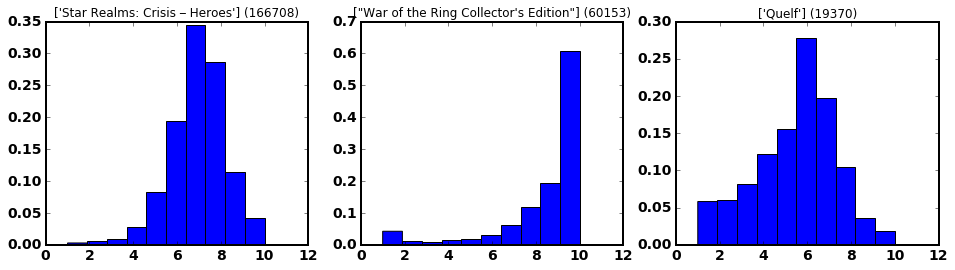

In [106]:
fig, axs = plt.subplots(figsize=[16, 4], nrows=1, ncols=3)
axs = axs.ravel()
for idx, game in enumerate(df_toy["id"].sample(n=3, random_state=999)):
    df = df_ratings[df_ratings["gameid"] == game]
    nm = df_toy.loc[df_toy["id"] == game, "name"].values
    __ = axs[idx].hist(df["rating"], bins=10, normed=True)
    axs[idx].set_title("%s (%i)" % (nm, game))
    print("%s Our Data: Mean = %.2f. StdDev = %.2f" % (nm, df["rating"].mean(), df["rating"].std()))
    
    # Request actual stats from the server to compare with scraped data
    r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%i&stats=1" % (game,))
    soup = BeautifulSoup(r.text, "xml")
    std = float(soup("stddev")[0]["value"])
    mn = float(soup("average")[0]["value"])
    print("%s Server Stats: Mean = %.2f. StdDev = %.2f" % (nm, mn,std))
    sleep(1.5)

I am confident now that we didn't do anything wildly wrong when gathering the ratings data!

### Restricting to Users with > 10 Ratings

To build our recommender system let's start by only keeping users who rated at least 10 of these games.

In [115]:
# A nifty and somewhat fault-tolerant way of constructing long SQL queries
sql = " ".join((
    "SELECT username",
    "FROM (SELECT username, count(*) as freqn FROM data GROUP BY username)",
    "AS tbl WHERE freqn > 10",
))

users = pd.read_sql_query(sql, connex)
users.sample(n=3)

,username
23795,pedro_pete
5630,JawnMan
19136,hurkle


In [120]:
usrs = ["'" + usr + "'" for usr in users["username"].values]
str_matching = "(" + ",".join(usrs) + ")"  # Construct the string of SQL language
sql = "SELECT * FROM data WHERE username IN " + str_matching + ";"
df_ratings = pd.read_sql_query(sql, connex)
df_ratings.sample(n=3)

,gameid,username,rating
458023,1822,tmarozas,7.5
911991,152,DangerMouse,5.0
826663,392,spindisc,7.0


This is starting to look good as the raw data for a simple recommender system! Let's do one last calculation on the sparsity of this ratings data. If every user in our toy set rated every movie in our toy data we'd have a sparsity of 100%. Instead we have:

In [123]:
max_n_ratings = len(df_ratings["gameid"].unique())*len(df_ratings["username"].unique())
actual_n_ratings = len(df_ratings)
print("Sparsity of Ratings Data is %.2f%%" % (100*actual_n_ratings/max_n_ratings))

Sparsity of Ratings Data is 3.62%


### Note on Requesting Collections  -  Request gets Queued
I haven't tried to query and collections info with the API, but I just wanted to includ this note for future work. See [forum post](https://boardgamegeek.com/thread/1188687/export-collections-has-been-updated-xmlapi-develop). You just keep re-running the query until you don't get a "Your request has been queued" response.

In [ ]:
r3 = requests.get("http://www.boardgamegeek.com/xmlapi2/collection?username=odo_ital&rated=1")
soup = BeautifulSoup(r3.text, "xml")
print(r3.status_code)
r3.text